# Classifying Pets' Emotions from Facial Expressions

In this project, I will utilize the Pet's Facial Expression Image Dataset from Kaggle to develop a classification model to identify the emotions of animals based on their faces. The aim of this project is to offer valuable insights for pet owners, enabling them to better understand the emotions of their pets and provide improved care.

To accomplish the objective, I will employ advanced techniques in deep learning, including convolutional neural networks (CNN) and transfer learning. Despite different pjysical features across the species in the dataset, the model is able to detecting the patterns that their emotions have in common. Using a fined tuned training model based on ResNet50, the validation datasets are classified with precision 55.56%. In particular, in the test data, it classifies 80% of the angry faces correctly, but performs less well on detecting other emotions.


## Downloading and Exploring the Data
First, let's download and explore the dataset. This section includes importing libraries, downloading the dataset from Kaggle, and exploratory analysis.






### Import the Libraries

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


### Download the Dataset from Kaggle

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset?resource=download'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dw1009
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset


100%|██████████| 38.6M/38.6M [00:00<00:00, 62.2MB/s]


In [ ]:
DATA_DIR = './pets-facial-expression-dataset'
print(os.listdir(DATA_DIR))

['Other', 'Master Folder', 'happy', 'Angry', 'Sad']


In [ ]:
print(os.listdir(DATA_DIR+'/Master Folder')[:10])

['test', 'valid', 'train']


In [ ]:
print(os.listdir(DATA_DIR+'/Angry')[:10])

['20.jpg', 'aug-71-91.jpg', 'aug-50-67.jpg', 'aug-92-24.jpg', 'aug-174-31.jpg', 'aug-44-57.jpg', 'aug-118-56.jpg', 'aug-14-21.jpg', '55.jpg', '27.jpg']


We can see from the data directory that the dataset includes 5 folders, including 4 facial expressions and a master folder. The master folder includes training, validation and test data.

### Exploratory Analysis
In this section, we try to answer the following questions.
1. How many images are there in the training, validation and test set?
2. What is the shape of an images
3. How many classes are there? What are they?
4. How many images are there in each class in the training set?
5. Show the first image and its label of the training set.


Q1. How many images are there in the training, validation and test set?

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(DATA_DIR+'/Master Folder/train', transform=ToTensor())
valid_ds = ImageFolder(DATA_DIR+'/Master Folder/valid', transform=ToTensor())
test_ds = ImageFolder(DATA_DIR+'/Master Folder/test', transform=ToTensor())

In [ ]:
train_size = len(train_ds)
valid_size = len(valid_ds)
test_size = len(test_ds)
print('Train size: ' + str(train_size) + '; Validation size: ' + str(valid_size) + '; Test size: ' + str(test_size))

Train size: 1000; Validation size: 36; Test size: 38


Q2. What is the shape of an image?

In [ ]:
img, label = train_ds[0]
img_shape = img.shape
img_shape

torch.Size([3, 224, 224])

Q3. How many classes are there? What are they?

In [ ]:
classes = train_ds.classes
classes

['Angry', 'Other', 'Sad', 'happy']

In [ ]:
num_classes = len(classes)
num_classes

4

Q4. How many images are there in each class in the training set?

In [ ]:
num_classes_list = [0] * num_classes

for num in range(train_size):
    img, label = train_ds[num]
    num_classes_list[label] += 1

num_classes_list

[250, 250, 250, 250]

Q5. Show the first image and its label in the training set.

Label (numeric): 0
Label (textual): Angry


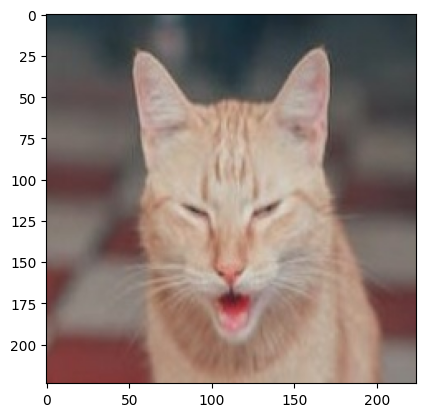

In [ ]:
img, label = train_ds[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

From the analysis above, we find the following.
- The training set includes 1000 images, the validation set includes 36 images, and the test set includes 28 images.
- Each image is an RGB image with 224 by 224 pixels.
- There are four classes: Angry, Other, Sad, Happy.
- In the training set, each class includes 250 images.
- The first image of the training set is a cat, and its label is Angry. The label shows the pet's emotions only, but not the species.

### Augmentation and Normalization
To add more variation to the data, we augment the images with the following steps.
- Pad each image by 4 pixels, using reflect padding mode to deal with the border.
- Take a random crop of size 170 by 170 pixels.
- Flip the image horizontally with 50% probability.
After these steps, the model sees slightly different images in each epoch, which allows it to generalize the patterns of the individual images better.


In addition, we apply normalization to the channels. The aim is to prevent disproportionate influence of the different channels on the gradient or losses because soem channels have larger number than others.

In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(170, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
# PyTorch datasets
train_ds = ImageFolder(DATA_DIR+'/Master Folder/train', train_tfms)
valid_ds = ImageFolder(DATA_DIR+'/Master Folder/valid', valid_tfms)
test_ds = ImageFolder(DATA_DIR+'/Master Folder/test', test_tfms)

In [ ]:
batch_size = 40

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In terms of data visualization, let's define a function that reverses the normalization process, and another function to show a batch of images altogether.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:50], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

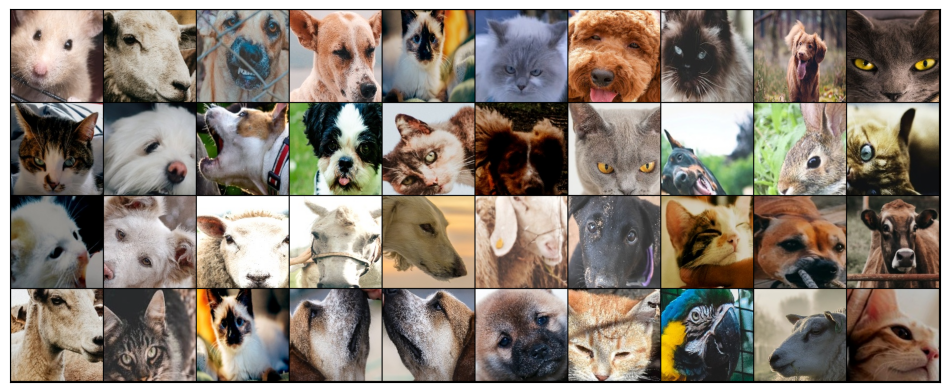

In [ ]:
show_batch(train_dl)

The batch of images include several species such as cats, dogs, horses, and hamsters. They have different facial expressions. Some faces are cropped probably due to the data augmentation. Their faces turn into different angles when facing the camera, which demands the model to recognize more subtle features in different parts of the animals' faces that express the emotions.

### Using the GPU
To use a GPU, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Train the Model

### Define the Base Class
We define the accuracy score as the proportion of the labels that are correctly predicted. In addition, let's define a base class named `Pets ClassificationBase` that includes the training and validation steps, as well as a function that stores the validation loss and accuracy using each epoch, and a function that prints the results.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class PetsClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Transfer Learning
We can use a pretrained model `ResNet50` that is known to be accurate in classification tasks. Let's use the model and fine tune it until it preforms our task well. To do so, the first step is to define a class that nests our base class `PetsClassificationBase`.

In [ ]:
class PetsModel(PetsClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

### Training and Improving Fit

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = PetsModel(len(train_ds.classes))
to_device(model, device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3816847801208496, 'val_acc': 0.3055555522441864}]

In [ ]:
model.freeze()


In [ ]:
epochs = 15
max_lr = 0.0005
grad_clip = 0.001
weight_decay = 0.00001
opt_func = torch.optim.Adam

In [ ]:
#
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.2039, val_loss: 1.2495, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5669, val_loss: 1.6161, val_acc: 0.5000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.1898, val_loss: 4.8741, val_acc: 0.5000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4064, val_loss: 8.3613, val_acc: 0.4167


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.4629, val_loss: 3.7406, val_acc: 0.5278


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3379, val_loss: 2.9219, val_acc: 0.4167


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1832, val_loss: 3.4299, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2208, val_loss: 2.5965, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1108, val_loss: 1.7821, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0545, val_loss: 2.2822, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0252, val_loss: 2.2864, val_acc: 0.5556


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0167, val_loss: 2.3610, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0036, val_loss: 2.3857, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0036, val_loss: 2.3984, val_acc: 0.3611


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0049, val_loss: 2.4466, val_acc: 0.3611
CPU times: user 45.9 s, sys: 38.2 s, total: 1min 24s
Wall time: 1min 40s


In [ ]:
#
%%time
history += fit_one_cycle(epochs, 0.00005, model, train_dl, valid_dl,
                         grad_clip = grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0050, val_loss: 2.3880, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0058, val_loss: 2.3274, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0037, val_loss: 2.5702, val_acc: 0.3611


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0032, val_loss: 2.4505, val_acc: 0.3611


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0112, val_loss: 2.2405, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0041, val_loss: 2.0811, val_acc: 0.5000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0061, val_loss: 1.9377, val_acc: 0.5278


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0049, val_loss: 2.1274, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0093, val_loss: 2.2212, val_acc: 0.5000


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0009, val_loss: 2.2346, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0013, val_loss: 2.2165, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0027, val_loss: 2.1828, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0047, val_loss: 2.2022, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0018, val_loss: 2.2103, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0025, val_loss: 2.2032, val_acc: 0.4444
CPU times: user 49.5 s, sys: 43 s, total: 1min 32s
Wall time: 1min 48s


In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0067, val_loss: 2.1260, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0014, val_loss: 1.9694, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0092, val_loss: 3.4728, val_acc: 0.4722


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0222, val_loss: 2.6361, val_acc: 0.4167


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0286, val_loss: 3.5704, val_acc: 0.4444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0243, val_loss: 3.0596, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0046, val_loss: 2.7837, val_acc: 0.3611


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0053, val_loss: 2.7100, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0012, val_loss: 2.6719, val_acc: 0.3889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0014, val_loss: 2.6410, val_acc: 0.3889
CPU times: user 33.2 s, sys: 28.8 s, total: 1min 1s
Wall time: 1min 11s


After traning with fine tuned parameters, the accuracy reaches 55.56%, so that the model can recognize the four types of emotions with slightly more than half accuracy. To reach higher accuracy, we may need to use a larger traning set, or a CNN model with more layers. Let's summarize this section by plotting some figures of how accuracy score, losses, and learning rate changes with epochs or batches.

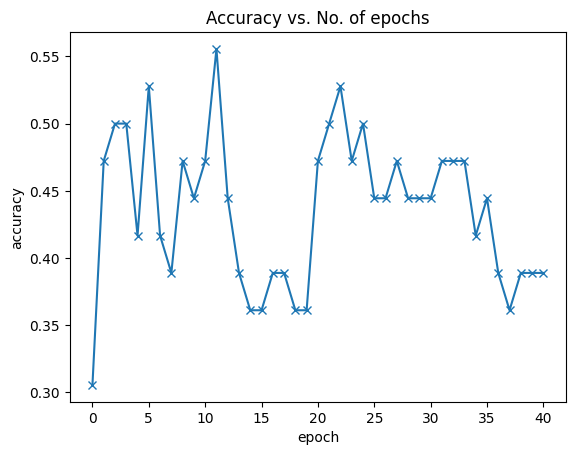

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

Overall, the accuracy score has an upward trend, suggesting our model improves the parameters using the data in each epoch. However, it fluctuates a lot, which may be due to the complexity of the data, or the choice of parameters. During training, I have used particularly small learning rate to mitigate this problem. It is also possible that the optimization has multiple local optimum, and we have achieved one of them.

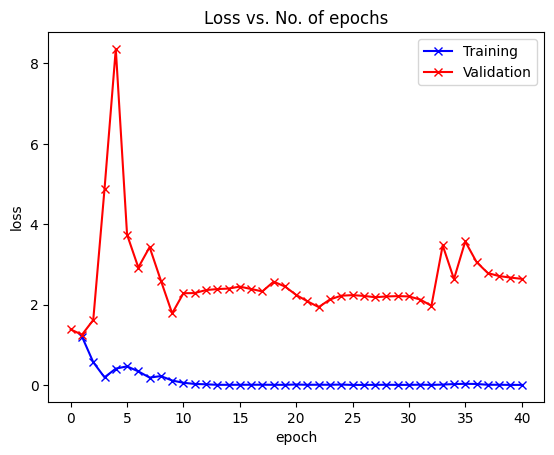

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

The loss from traning has always been very small and decreases slightly. The validation error spikes and then decreases sharply, and increases slightly after that. This suggests there may be overfitting problems to some extent. However, the accuracy of the validation has been improving, which suggests there may be a discrepancy between the goals of minimizing validation loss and increasing the accuracy score.

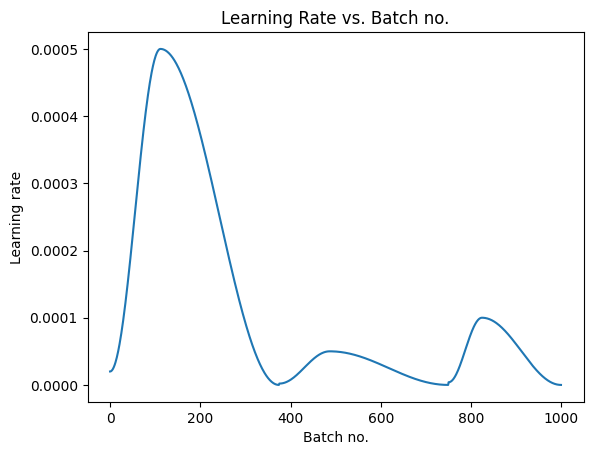

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

The learning rate increases for the first hundred or so batches, and decreaes after that, so that the model adjusts in a slower but more steady way. There are two small spikes after the first one, suggesting there is some volatility in optimization, probably because the optimization problem is not a smooth one.

## Making Predictions
Next, we will use this model to make some predictions with the test set and visualize them.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Angry , Predicted: Sad


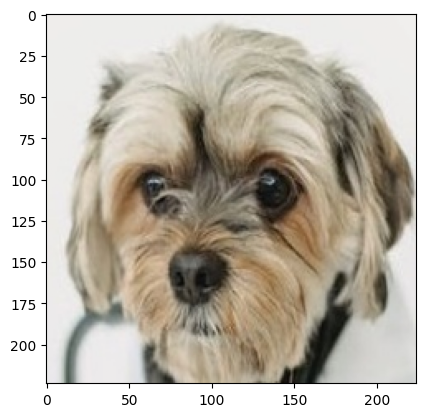

In [ ]:
img, label = valid_ds[5]
denorm_images = denormalize(img, *stats)
plt.imshow(make_grid(denorm_images[:50], nrow=10).permute(1, 2, 0).clamp(0,1))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Angry , Predicted: Angry


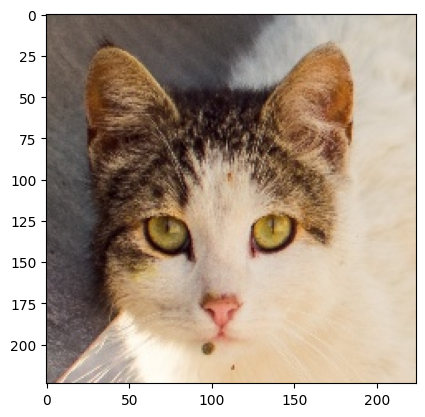

In [ ]:
img, label = test_ds[7]
denorm_images = denormalize(img, *stats)
plt.imshow(make_grid(denorm_images[:50], nrow=10).permute(1, 2, 0).clamp(0,1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: happy , Predicted: Angry


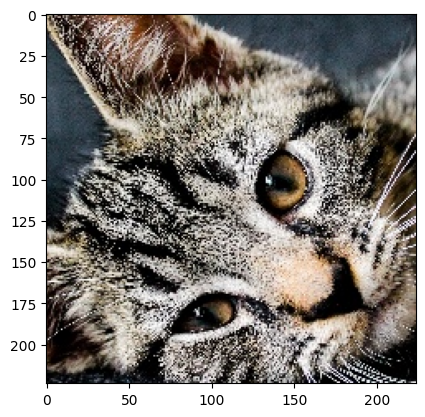

In [ ]:
img, label = test_ds[37]
denorm_images = denormalize(img, *stats)
plt.imshow(make_grid(denorm_images[:50], nrow=10).permute(1, 2, 0).clamp(0,1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Other , Predicted: Angry


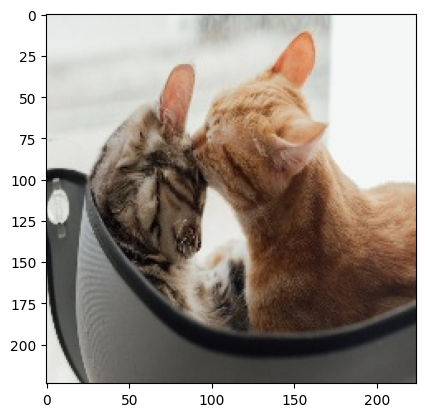

In [ ]:
img, label = test_ds[14]
denorm_images = denormalize(img, *stats)
plt.imshow(make_grid(denorm_images[:50], nrow=10).permute(1, 2, 0).clamp(0,1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Angry , Predicted: Angry


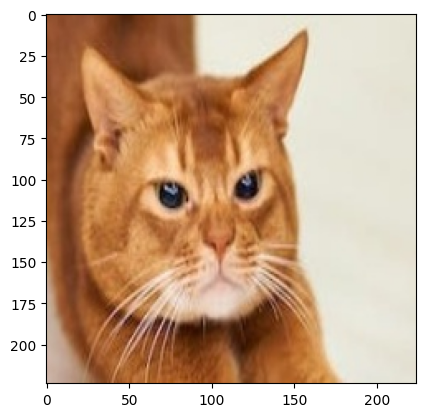

In [ ]:
img, label = test_ds[3]
denorm_images = denormalize(img, *stats)
plt.imshow(make_grid(denorm_images[:50], nrow=10).permute(1, 2, 0).clamp(0,1))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

There are only 38 images in the test set, which allows us to visualize all of them and compare the actual labels with the predicted ones.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


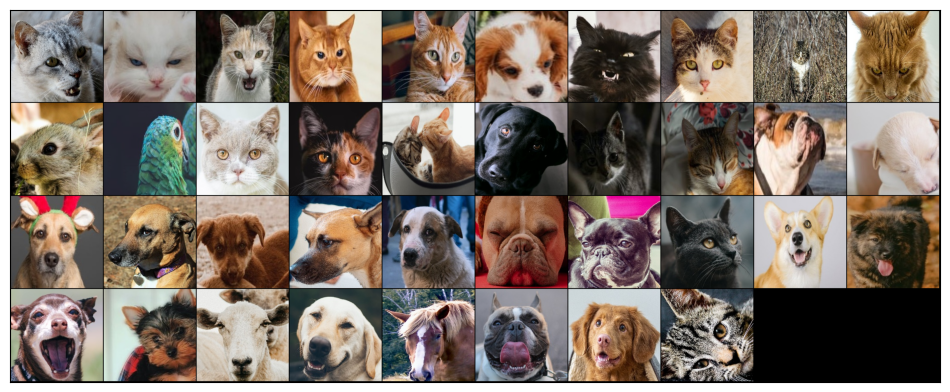

In [ ]:
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)
show_batch(test_dl)

In [ ]:
actual_label = []
predicted_label = []
for img, label in test_ds:
  actual_label += [test_ds.classes[label]]
  predicted_label += [predict_image(img, model)]



In [ ]:
import pandas as pd
test_preds_label = pd.DataFrame({'Actual Labels':actual_label, 'Predicted Label': predicted_label})
test_preds_label

Actual Labels Predicted Label
0          Angry           Angry
1          Angry           Angry
2          Angry           Angry
3          Angry           Angry
4          Angry           Angry
5          Angry           happy
6          Angry           Angry
7          Angry           Angry
8          Angry           happy
9          Angry           Angry
10         Other           Angry
11         Other           Angry
12         Other             Sad
13         Other           Angry
14         Other           Angry
15         Other             Sad
16           Sad           happy
17           Sad           Angry
18           Sad           happy
19           Sad           Angry
20           Sad             Sad
21           Sad           happy
22           Sad             Sad
23           Sad             Sad
24           Sad             Sad
25           Sad             Sad
26           Sad           Other
27         happy           Angry
28         happy           happy
29         happy           happy
30         happy           happy
31         happy           Angry
32         happy             Sad
33         happy           happy
34         happy           Angry
35         happy             Sad
36         happy           happy
37         happy           Angry

In [ ]:
test_preds_label['Correct'] = (test_preds_label['Actual Labels'] == test_preds_label['Predicted Label']).astype(int)
test_accuracy = test_preds_label.groupby(['Actual Labels'], as_index = False)[['Correct']].mean()
test_accuracy

Actual Labels   Correct
0         Angry  0.800000
1         Other  0.000000
2           Sad  0.454545
3         happy  0.454545

From the table above, we can see the model performs very well in detecting angry faces of the pets. It detects sad or happy faces with a bit lower than 50% precision, but performs badly in detecting other faces. In particular, it recognizes "other" faces as one of angry, happy, or sad faces. It may be the case that "other" faces lack patterns in common that can be picked up during training. If we compare the images that were predicted correctly versus those incorrectly within happy or sad category, it is true that the former images express the feelings more clearly, while the latter images are more subtle.

## Saving and Committing

In [ ]:
torch.save(model.state_dict(), 'pet_resnet50.pth')


In [ ]:
!pip install jovian
import jovian
jovian.reset()
jovian.log_hyperparams(arch='resnet50',
                       epochs=epochs,
                       lr=max_lr,
                       scheduler='one-cycle',
                       weight_decay=weight_decay,
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6479 sha256=4bfac5dab10f5def5b9d1ccdc456b192cab2d8c9aec3864227cf48439a44709d
  Stored in directory: /root/.cache/pip/wheels/ed/08/9e/f0a977dfe55051a07e21af89200125d65f1efa60cbac61ed88
Successfully built uuid


[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Conclusions
### Summary
In this project, we have trainined a model to classify the pet's emotions. We have used transfer learning based on ResNet50. The model achieves 55.56% accuracy score, and performs very well at predicting certain labels.

### Future Learning
Future work can focus on the follows.
- Use more complex models to capture the patterns of the data, especially for "other" category.
- Interpret and mitigate the discrepancy between optimizing the losses and the accuracy scores.
- Explore the possibility of multiple optima in the optimization process.

### References
- https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset

- https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets

- https://jovian.com/outlink?url=https%3A%2F%2Fjovian.ai%2Faakashns%2Ftransfer-learning-pytorch